In [18]:
# [Load packages]

# To call functions outside of this folder
import sys  
sys.path.insert(0, '..')

import pandas as pd
from src.forecaster import Forecaster
from src.analyser import Analyser
import logging



# Load data and fit forecaster

In [19]:
# [Load data]
data = pd.read_csv(
    '../data/multivariate/blow_mold_preprocessed.csv', 
    index_col='datetime', 
    parse_dates=['datetime'])

print('Filtered out only y and gas_regm columns')
data = data[['y', 'gas_regm']]

data.head(3)

Filtered out only y and gas_regm columns


y  gas_regm
datetime                  
2000-01-31  41.0     1.289
2000-02-29  41.0     1.377
2000-03-31  45.0     1.516

In [26]:
# [Init forecaster]

window_length = 12 # Auto correlation, lags
n_predict = 12 # Forecast horizon

forecaster = Forecaster()
forecaster.fit(data, n_predict=n_predict, window_length=window_length)

[Forecaster - fit] ----- START -----
[Forecaster - fit] Train test split
[Forecaster - fit] Test size:  12
[Forecaster - fit] Sliding window splitter, with window_length 276 and fh 12
[Forecaster - fit] ----- END -----


In [27]:
forecaster.data

y  gas_regm
datetime                  
2000-01-31  41.0     1.289
2000-02-29  41.0     1.377
2000-03-31  45.0     1.516
2000-04-30  47.0     1.465
2000-05-31  47.0     1.487
...          ...       ...
2022-08-31  93.0     3.975
2022-09-30  90.0     3.700
2022-10-31  90.0     3.815
2022-11-30  90.0     3.685
2022-12-31  90.0     3.210

[276 rows x 2 columns]

In [28]:
# [Build exogenous data for testing, with weekday and datetime column]

exog_index = pd.date_range("2000-01-31", "2023-12-31", freq='M')
exog_weekday = exog_index.weekday
exog = pd.DataFrame({'weekday':exog_weekday}, index=exog_index)

In [32]:
exog

weekday
2000-01-31        0
2000-02-29        1
2000-03-31        4
2000-04-30        6
2000-05-31        2
...             ...
2023-08-31        3
2023-09-30        5
2023-10-31        1
2023-11-30        3
2023-12-31        6

[288 rows x 1 columns]

In [29]:
# [Fit forecaster with new exog column]

forecaster.fit(data, n_predict=n_predict, window_length=window_length, exog=exog)

[Forecaster - fit] ----- START -----
[Forecaster - fit] - exogenous data provided
[Forecaster - fit] - merge exogenous data with features
[Forecaster - fit] Train test split
[Forecaster - fit] Test size:  12
[Forecaster - fit] Sliding window splitter, with window_length 276 and fh 12
[Forecaster - fit] ----- END -----


In [49]:
data.merge(exog, left_index=True, right_index=True).reset_index().rename(columns={'index':'datetime'}).to_csv('../data/multivariate/demo_historical.csv', index=False)

In [50]:
exog[-12:-8].reset_index().rename(columns={'index':'datetime'}).to_csv('../data/multivariate/demo_future.csv', index=False)

In [40]:
forecaster.fh.to_pandas()

DatetimeIndex(['2023-01-31', '2023-02-28', '2023-03-31', '2023-04-30',
               '2023-05-31', '2023-06-30', '2023-07-31', '2023-08-31',
               '2023-09-30', '2023-10-31', '2023-11-30', '2023-12-31'],
              dtype='datetime64[ns]', freq='M')

In [15]:
# [Predict without exog golumns]

forecaster.forecast(test=True)

Init model ...
Init model ...


/home/zq/miniconda3/lib/python3.10/site-packages/sktime/forecasting/model_selection/_tune.py:198: UserWarning: in ForecastingRandomizedSearchCV, n_jobs and pre_dispatch parameters are deprecated and will be removed in 0.26.0. Please use n_jobs and pre_dispatch directly in the backend_params argument instead.
  warn(
/home/zq/miniconda3/lib/python3.10/site-packages/sktime/forecasting/model_selection/_tune.py:198: UserWarning: in ForecastingRandomizedSearchCV, n_jobs and pre_dispatch parameters are deprecated and will be removed in 0.26.0. Please use n_jobs and pre_dispatch directly in the backend_params argument instead.
  warn(
/home/zq/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 70 is smaller than n_iter=100. Running 70 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/zq/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reache

[{'model': 'xgbreg',
  'results': {'forecast': datetime
   2022-09-30    84.053032
   2022-10-31    68.322166
   2022-11-30    66.457939
   2022-12-31    66.370132
   Freq: M, Name: y, dtype: float64,
   'best_score': 0.02539743402952789,
   'best_params': {'estimator__subsample': 0.5,
    'estimator__n_estimators': 500,
    'estimator__max_depth': 15,
    'estimator__learning_rate': 0.2,
    'estimator__colsample_bytree': 0.7999999999999999,
    'estimator__colsample_bylevel': 0.4}}},
 {'model': 'mlr',
  'results': {'forecast': datetime
   2022-09-30    88.663381
   2022-10-31    84.754162
   2022-11-30    82.534963
   2022-12-31    81.363169
   Freq: M, Name: y, dtype: float64,
   'best_score': 0.12320369211901486,
   'best_params': {'estimator__solver': 'sparse_cg',
    'estimator__fit_intercept': False,
    'estimator__alpha': 10}}}]

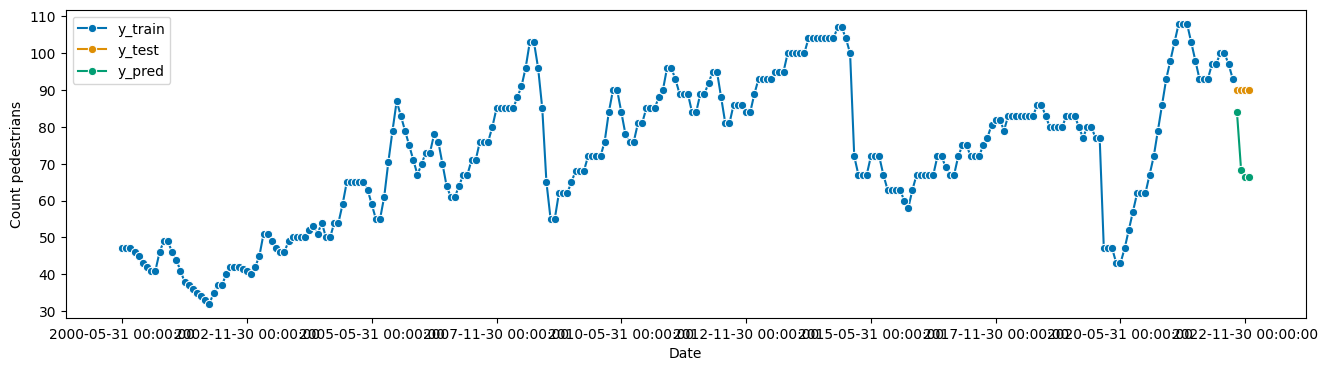

In [16]:
from sktime.utils.plotting import plot_series

plot_series(
    forecaster.y_train, 
    forecaster.y_test, 
    forecaster.results[0]['results']['forecast'], 
    labels=["y_train", "y_test", "y_pred"], 
    x_label='Date', 
    y_label='Count pedestrians');

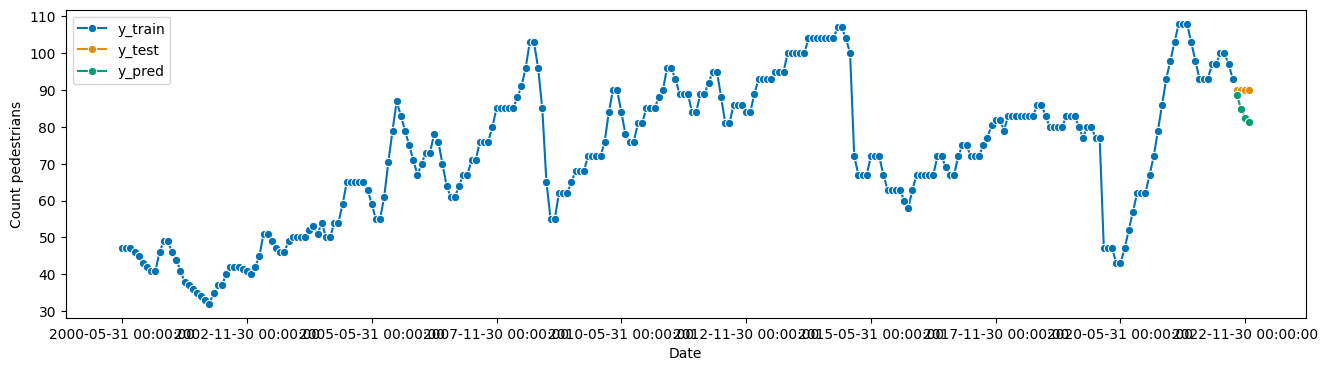

In [17]:
from sktime.utils.plotting import plot_series

plot_series(
    forecaster.y_train, 
    forecaster.y_test, 
    forecaster.results[1]['results']['forecast'], 
    labels=["y_train", "y_test", "y_pred"], 
    x_label='Date', 
    y_label='Count pedestrians');

# Config XGBoostRegressor model and perform random search CV

[Reference](https://towardsdatascience.com/build-complex-time-series-regression-pipelines-with-sktime-910bc25c96b6)

In [6]:
# [Build the Linear Regression Model]

from sklearn.linear_model import LinearRegression
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.base import ForecastingHorizon

regressor = LinearRegression()
lr_forecastor = make_reduction(regressor, window_length=window_length, strategy="recursive")

lr_forecastor.fit(forecaster.y_train, forecaster.X_train)
y_pred = lr_forecastor.predict(forecaster.fh_test, forecaster.X_test)

In [8]:
# [Plot forecasting result, evaluate MAPE]

from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

plot_series(forecaster.y_train['2018-07-01':], forecaster.y_test, y_pred, labels=["y_train", "y_test", "y_pred"], x_label='Date', y_label='Count pedestrians');

print('MAPE: %.4f' % mean_absolute_percentage_error(forecaster.y_test, y_pred, symmetric=False))

NameError: name 'y_pred' is not defined

MAPE: 0.2268


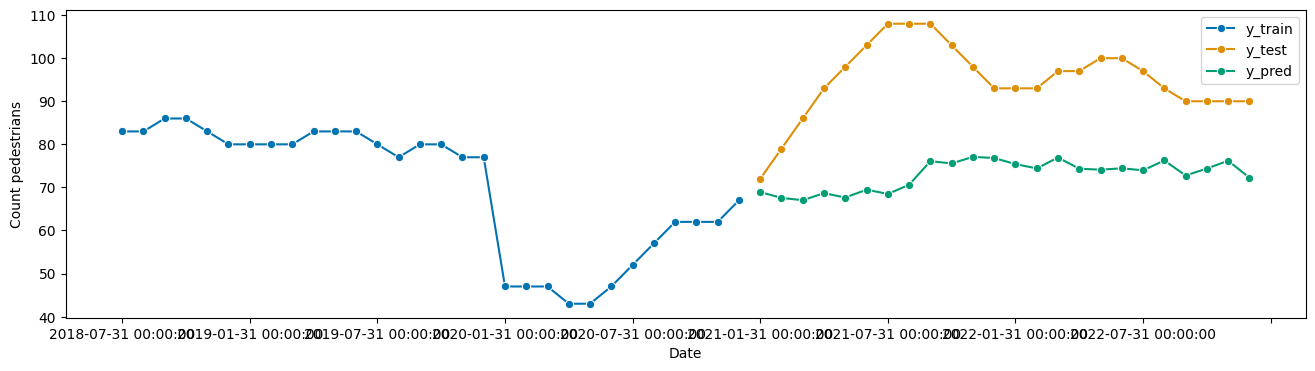

In [ ]:
# [Build XGBoost model with grid search for best parameters]

from xgboost import XGBRegressor
regressor = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_forecaster = make_reduction(regressor, window_length=window_length, strategy="recursive")

xgb_forecaster.fit(forecaster.y_train, forecaster.X_train)
y_pred = xgb_forecaster.predict(forecaster.fh_test, forecaster.X_test)

plot_series(forecaster.y_train['2018-07-01':], forecaster.y_test, y_pred, labels=["y_train", "y_test", "y_pred"], x_label='Date', y_label='Count pedestrians');

print('MAPE: %.4f' % mean_absolute_percentage_error(forecaster.y_test, y_pred, symmetric=False))

# Hyperparameters Tuning

In [ ]:
# [Perform grid search]
from xgboost import XGBRegressor
from sktime.forecasting.compose import make_reduction

from sktime.forecasting.model_selection import SingleWindowSplitter
from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV
import numpy as np

# Create validation set
validation_size = 12
cv = SingleWindowSplitter(window_length= 24, fh=len(forecaster.fh))

param_grid = {
    # 'estimator__max_depth': [3, 5, 6, 10, 15, 20],
    # 'estimator__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'estimator__subsample': np.arange(0.5, 1.0, 0.1),
    'estimator__colsample_bytree': np.arange(0.4, 1.0, 0.1),
    'estimator__colsample_bylevel': np.arange(0.4, 1.0, 0.1),
    'estimator__n_estimators': [100, 500, 1000]
}

regressor = XGBRegressor(objective='reg:squarederror', random_state=42)

xgb_forecaster = make_reduction(
    regressor, 
    window_length=window_length, 
    strategy="recursive")

gscv = ForecastingRandomizedSearchCV(
    xgb_forecaster, 
    cv=cv, 
    param_distributions=param_grid, 
    n_iter=100, 
    random_state=42,
    error_score="raise")

gscv.fit(y = forecaster.y_train, X=forecaster.X_train)

y_pred = gscv.predict(fh=forecaster.fh_test, X=forecaster.X_test)

/home/zq/miniconda3/lib/python3.10/site-packages/sktime/forecasting/model_selection/_tune.py:198: UserWarning: in ForecastingRandomizedSearchCV, n_jobs and pre_dispatch parameters are deprecated and will be removed in 0.26.0. Please use n_jobs and pre_dispatch directly in the backend_params argument instead.
  warn(


In [ ]:
len(forecaster.fh_test)

12

In [ ]:
len(forecaster.fh)

12

In [ ]:
from sktime.forecasting.model_selection import SlidingWindowSplitter
cv = SlidingWindowSplitter(window_length=  window_length, fh=len(forecaster.fh_test))

[i for i in cv.split(forecaster.y_train)]


[(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), array([35])),
 (array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([36])),
 (array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]), array([37])),
 (array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), array([38])),
 (array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]), array([39])),
 (array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]), array([40])),
 (array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]), array([41])),
 (array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18]), array([42])),
 (array([ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]), array([43])),
 (array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]), array([44])),
 (array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]), array([45])),
 (array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]), array([46])),
 (array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]), array([47])),
 (array([13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23

In [ ]:
# [Grid search cv results]

print(gscv.best_params_)
print(gscv.best_score_)

{'estimator__n_estimators': 100}
0.15297129616808536


(<Figure size 1600x400 with 1 Axes>,
 <Axes: xlabel='Date', ylabel='Count pedestrians'>)

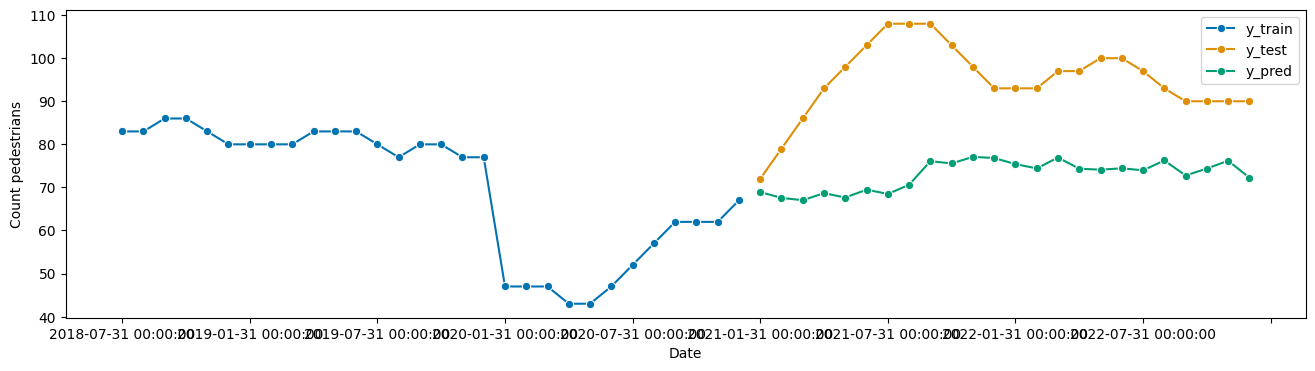

In [ ]:
# [Plot grid search cv results]

y_pred = gscv.predict(forecaster.fh_test, forecaster.X_test)

plot_series(forecaster.y_train['2018-07-01':], forecaster.y_test, y_pred, labels=["y_train", "y_test", "y_pred"], x_label='Date', y_label='Count pedestrians')

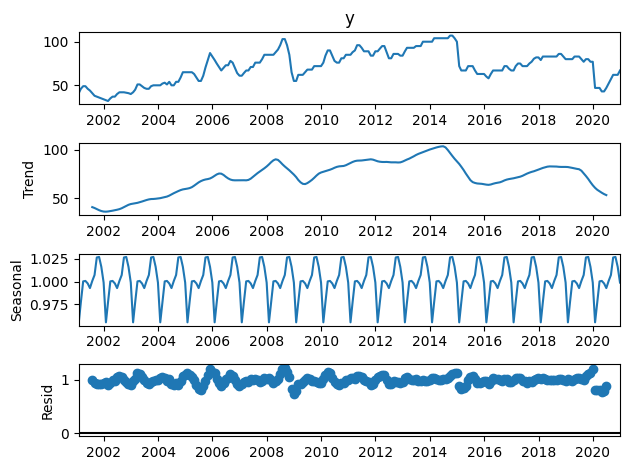

In [ ]:
# [Perform seasonal decompose]

import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(forecaster.y_train, model='multiplicative')
result.plot()
plt.show()


In [ ]:
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster

regressor = XGBRegressor(objective='reg:squarederror', random_state=42)
transformer_forecaster = TransformedTargetForecaster(
    [
        # ("deseasonalize", Deseasonalizer(model="additive", sp=forecaster.period)),
        # ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        ("forecast", make_reduction(regressor, window_length=window_length, strategy="recursive"),
        ),
    ]
)

param_grid = {
    # 'deseasonalize__model': ['multiplicative', 'additive'],
    # 'detrend__forecaster__degree': [1, 2, 3],
    'forecast__estimator__max_depth': [3, 5, 6, 10, 15, 20],
    'forecast__estimator__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'forecast__estimator__subsample': np.arange(0.5, 1.0, 0.1),
    'forecast__estimator__colsample_bytree': np.arange(0.4, 1.0, 0.1),
    'forecast__estimator__colsample_bylevel': np.arange(0.4, 1.0, 0.1),
    'forecast__estimator__n_estimators': [100, 500, 1000]
}
gscv = ForecastingRandomizedSearchCV(transformer_forecaster, cv=cv, param_distributions=param_grid, n_iter=2, random_state=42, error_score='raise')

gscv.fit(y=forecaster.y_train, X=forecaster.X_train)

y_pred = gscv.predict(fh=forecaster.fh_test, X=forecaster.X_test)

/home/zq/miniconda3/lib/python3.10/site-packages/sktime/forecasting/model_selection/_tune.py:198: UserWarning: in ForecastingRandomizedSearchCV, n_jobs and pre_dispatch parameters are deprecated and will be removed in 0.26.0. Please use n_jobs and pre_dispatch directly in the backend_params argument instead.
  warn(


MAPE: 0.2330


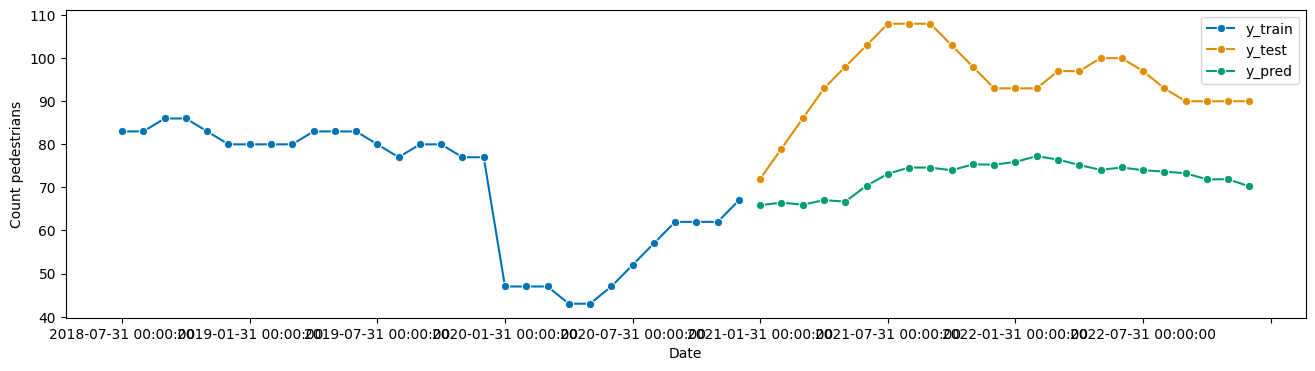

In [ ]:
plot_series(forecaster.y_train['2018-07-01':], forecaster.y_test, y_pred, labels=["y_train", "y_test", "y_pred"], x_label='Date', y_label='Count pedestrians')

print('MAPE: %.4f' % mean_absolute_percentage_error(forecaster.y_test, y_pred, symmetric=False))

MAPE: 0.3751


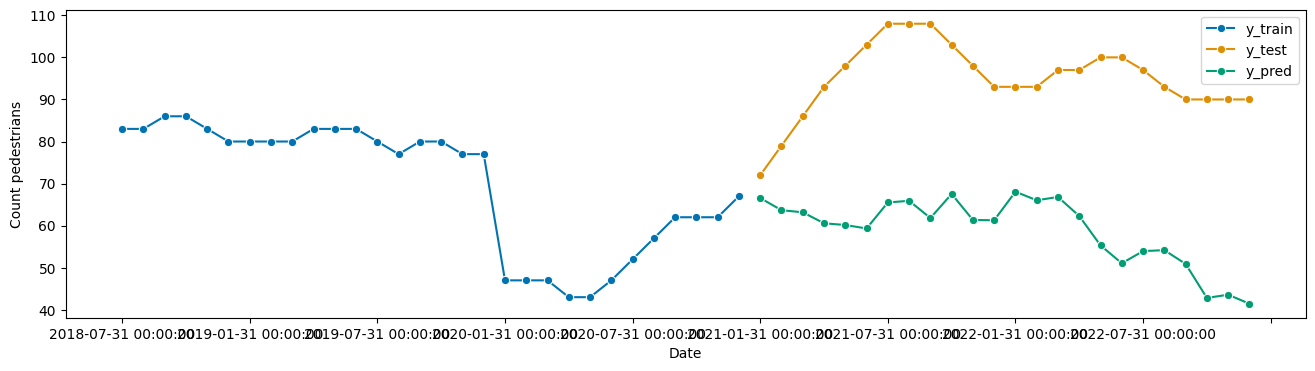

In [ ]:
plot_series(forecaster.y_train['2018-07-01':], forecaster.y_test, y_pred, labels=["y_train", "y_test", "y_pred"], x_label='Date', y_label='Count pedestrians')

print('MAPE: %.4f' % mean_absolute_percentage_error(forecaster.y_test, y_pred, symmetric=False))